# Final Project
Prepared by:
* Mira Dannawi



For this project, we downloaded the SMS Spam Collection data set from:<br>
https://archive.ics.uci.edu/ml/machine-learning-databases/00228/<br>
and we want to build a Naivee Bayes spam filter.

In [2]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading the data into a Python data frame

The data was available in the format of text file, so we converted it into an excel file under the name of Group.xlsx

In [3]:
data = pd.read_excel('Group.xlsx', header = None, names=['label','text'])

#### Exploratory Data Analysis

In [4]:
data.shape

(5572, 2)

In [5]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


In [7]:
print(np.array(data.label[:5]))
print('-'*60)
print(np.array(data.text[:5]))

['ham' 'ham' 'spam' 'ham' 'ham']
------------------------------------------------------------
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
 'Ok lar... Joking wif u oni...'
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
 'U dun say so early hor... U c already then say...'
 "Nah I don't think he goes to usf, he lives around here though"]


## Preprocessing the SMS messages: Removing all punctuations and numbers from the SMS messages, and changing all messages to lowercase. 

In [8]:
# Pre-Processing

# Making sure Python perceives our text messages as strings
data.text = data.text.astype(str)

# Removing punctuations
from string import punctuation
data.text = data.text.str.translate(str.maketrans('', '', punctuation))

# Removing digits
from string import digits
data.text = data.text.str.translate(str.maketrans('', '', digits))

# Changing all messages to lowercase
data.text = data.text.str.lower()

In [9]:
print(np.array(data.label[:5]))
print('-'*60)
print(np.array(data.text[:5]))

['ham' 'ham' 'spam' 'ham' 'ham']
------------------------------------------------------------
['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'
 'ok lar joking wif u oni'
 'free entry in  a wkly comp to win fa cup final tkts st may  text fa to  to receive entry questionstd txt ratetcs apply overs'
 'u dun say so early hor u c already then say'
 'nah i dont think he goes to usf he lives around here though']


## Shuffling the messages and splitting them into a training set (2500 messages), a validation set (1000 messages) and a test set (all remaining message).

In [10]:
from sklearn.utils import shuffle #a function to shuffle the dataset

# Shuffle the data. Notice how indices are not ordered anymore
data = shuffle(data, random_state = 42)

# Split the data

train = data[:2500] #training data
valid = data[2500:2500 + 1000] #validation data
test = data[2500 + 1000:] #testing data

## While Python's SciKit-Learn library has a Naive Bayes classifier, it works with continuous probability distributions and assumes numerical features. Although it is possible to transform categorical variables into numerical features using a binary encoding, we will instead build a simple Naive Bayes classifier from scratch:

In [11]:
class NaiveBayesForSpam:
    def train (self, hamMessages,spamMessages):
        self.words = set(' '.join(hamMessages + spamMessages).split())
        self.priors = np.zeros(2)
        self.priors[0] = float(len(hamMessages)) / (len(hamMessages) + len(spamMessages))
        self.priors[1] = 1.0 - self.priors[0]
        self.likelihoods = []
        
        for i, w in enumerate(self.words):
            prob1 = (1.0 + len([m for m in hamMessages if w in m])) / len(hamMessages)
            prob2 = (1.0 + len([m for m in spamMessages if w in m])) / len(spamMessages)
            self.likelihoods.append([min(prob1, 0.95), min(prob2, 0.95)])
            
        self.likelihoods = np.array(self.likelihoods).T
        
    def train2 (self, hamMessages, spamMessages):
        self.words = set(' '.join(hamMessages + spamMessages).split())
        self.priors = np.zeros(2)
        self.priors[0] = float(len(hamMessages)) / (len(hamMessages) + len(spamMessages))
        self.priors[1] = 1.0 - self.priors[0]
        spamkeywords = []
        self.likelihoods = []
        
        for i, w in enumerate(self.words):
            prob1 = (1.0 + len([m for m in hamMessages if w in m])) / len(hamMessages)
            prob2 = (1.0 + len([m for m in spamMessages if w in m])) / len(spamMessages)
            if prob1 * 20 < prob2:
                self.likelihoods.append([min(prob1, 0.95), min(prob2, 0.95)])
                spamkeywords.append(w)
        self.words = spamkeywords
        self.likelihoods = np.array(self.likelihoods).T

    def predict(self, message, thresh = 0.5):#we added a threshold parameter to use it later on when testing the function
        posteriors = np.copy(self.priors)
        
        for i, w in enumerate(self.words):
            if w in message.lower(): #convert to lowercase
                posteriors *= self.likelihoods[:,i]
            else:
                posteriors *= np.ones (2) - self.likelihoods[:,i]
            posteriors = posteriors / np.linalg.norm(posteriors, ord = 1) #normalize
            
        if posteriors[0] > thresh:
            return ['ham', posteriors[0]]
        return['spam', posteriors[1]]

    def score(self, messages, labels, thresh = 0.5):#we added a threshold parameter to use it later on when testing the function
        confusion = np.zeros(4).reshape(2,2)
        for m, l in zip(messages, labels):
            if self.predict(m, thresh)[0] == 'ham' and l == 'ham':
                confusion[0,0] += 1
            elif self.predict(m, thresh)[0] == 'ham' and l == 'spam':
                confusion[0,1] += 1
            elif self.predict(m, thresh)[0] == 'spam' and l == 'ham':
                confusion[1,0] += 1
            elif self.predict(m, thresh)[0] == 'spam' and l == 'spam':
                confusion[1,1] += 1
        return (confusion[0,0] + confusion[1,1]) / float(confusion.sum()), confusion
    

## What is the purpose of each function? What do ''train'' and ''train2'' do, and what is the difference between them? Where in the code is Bayes' Theorem being applied?

NaiveBayesForSpam is a class, a classifier written to filter messages between "spam" messages and "ham" messages (not "spam"). NaiveBayesForSpam has four methods: "train", "train2", "predict", and "score".

"train" and "train2" are two methods to train NaiveBayesForSpam for filtering messages. Training the classifier requires us to split our data (our messages) to two sets: a training set and a validation set. After training NaiveBayesForSpam with the training set, "predict" will predict whether a message in the validation set is "ham" or "spam".

Given that this is a supervised learning and we already have labels for our sets (we already know which messages are "spam" and which are not), we would like to evaluate the classifier's performance, using the method "score". "score" generates a confision matrix: a 2x2 matrix that counts which "spam" and "ham" messages were predicted correctly, and which were not. Moreover, "score" will give us an accuracy score, which is the total number of all messages that were predicted correctly, divided by the total number of all messages, along with the false positives(ham messages classified as spam) and false negatives(spam messages classified as ham).

<u>train:</u><br>

* Split the training set into a ham list and a spam list

* Join the ham and spam lists into a set called words

* Create a set called "priors" of length 2. The first element is the prior probaibility of ham, and the second element is the prior probability of spam.

* Initiate an array of likelihoods.

* Loop over the set of words.

* We compute the probability of the likelihood of observing w in hamMessages  +1 in order to prevent any 0 probability(laplace estimator)(P(w|ham)): posterior probability of w after observing hamMessages.

* We compute the probability of the likelihood of observing w in spamMessages  +1 in order to prevent any 0 probability(laplace estimator)(P(w|ham)): posterior probability of w after observing spamMessages.

* We append both probabilities of each word into the likelihoods set.
<br>

<u>train2:</u><br>
* Split the training set into a ham list and a spam list

* Join the ham and spam lists into a set called words

* Create a set called "priors" of length 2. The first element is the prior probaibility of ham, and the second element is the prior probability of spam.

* Initiate an array of likelihoods.

* Initiate an array of spam keywords<br>

* Loop over the set of words<br>

* We compute the probability of the likelihood of observing w in hamMessages  +1 in order to prevent any 0 probability(laplace estimator)(P(w|ham)): posterior probability of w after observing hamMessages<br>

* We compute the probability of the likelihood of observing w in spamMessages  +1 in order to prevent any 0 probability(laplace estimator)(P(w|ham)): posterior probability of w after observing spamMessages<br>

* If probability of the occurance of the word in a ham message is less than 0.05 i.e approxiamtely 0 and is way less than the probability to occur in a spam message<br>

* Then we append these probabilities into the likelihoods array with keeping the probabilities less than 0.95 to prevent any probability to be equal to 1(laplace estimator)<br>

* Then we append the word to the spam keywords since it has shown a high probability to occur in spam messages<br>

* We then assign to the words array the spamkeywords array<br>

## Training the classifiers ''train'' and ''train2'' using the training set .

In [12]:
# Split training texts between ham texts and spam texts
train_ham_text = list(train[train['label'] == 'ham']['text'])
train_spam_text = list(train[train['label'] == 'spam']['text'])
valid_text = list(valid['text'])
test_text = list(test['text'])

In [13]:
# Initiate our class object.
NB = NaiveBayesForSpam()
NB2 = NaiveBayesForSpam() #to predict labels using "train2" instead of "train"

In [14]:
# Train our object, using "train" and "train2"
NB.train(hamMessages = train_ham_text,spamMessages = train_spam_text)
NB2.train2(hamMessages = train_ham_text,spamMessages = train_spam_text)

## Using the validation set, we explore how each of the two classifiers performs out of sample.

In [15]:
import timeit
start = timeit.default_timer()
acc1, cmat1 = NB.score(valid_text, valid['label'])
print("Confusion matrix: ")
print(cmat1)
print('-'*35)
print("Accuracy score: ", acc1)

Confusion matrix: 
[[839.  15.]
 [ 15. 131.]]
-----------------------------------
Accuracy score:  0.97


In [16]:
print("Time: ", round(timeit.default_timer()-start, 2)," seconds")

Time:  229.44  seconds


In [17]:
import timeit
start = timeit.default_timer()
acc2, cmat2 = NB2.score(valid_text, valid['label'])
print("Confusion matrix: ")
print(cmat2)
print('-'*35)
print("Accuracy score: ", acc2)

Confusion matrix: 
[[854.  32.]
 [  0. 114.]]
-----------------------------------
Accuracy score:  0.968


In [18]:
print("Time: ", round(timeit.default_timer()-start, 2)," seconds")

Time:  11.24  seconds


## Why is the 'train2' classifier faster?

Train2 classifier is much faster than the train classifier; it only needs 11 seconds to be executed compared to 229 seconds that train takes to operate. This is due to the fact that train2 only filters the spam words, and appends its posteriors probabilities to the likelihoods set while the train classifier appends the posterior probabilities of all of the words of the training set to the likelihoods set whether spam or ham. Therefore, the likelihoods set in train2 contains only the posteriors probabilities of  spam words of the training set, whereas the likelihoods set in train includes the posteriors probabilities of all of the ham and spam messages of the training set.

## How many false positives (ham messages classified as spam messages) is there in the validation set? How would the code be changed to reduce false positives at the expense of possibly having more false negatives (spam messages classified as ham messages)?

In [19]:
NB.score(valid_text, valid['label'], thresh = 0.8)

(0.97, array([[839.,  15.],
        [ 15., 131.]]))

In [20]:
NB.score(valid_text, valid['label'], thresh = 0.2)

(0.973, array([[843.,  16.],
        [ 11., 130.]]))

In [21]:
NB.score(valid_text, valid['label'], thresh = 0.5)

(0.97, array([[839.,  15.],
        [ 15., 131.]]))

For the train classifier, by passing the arguments validation texts and validation labels to the score method, the confusion matrix that we have got above has shown that the false positives(ham messages classified as spam) equal 15 for a 0.5 threshold(default threshold).

Likewise, for the train2 classifier, by passing the arguments validation texts and validation labels to the score method, we got false positives equal to 0.

However, to reduce the false positives in the train classifier, one has to do little modifications at the level of the predict method; instead of checking if the posterior probability of ham is higher than 0.5(threshold),set it at a threshold lower than 0.5. One can check, by recording the fasle positives and the accuracy score at thresholds higher and lower than 0.5, that a threshold lower than 0.5 gives lower false positives and higher accuracy score(like a threshold of 0.2 gives 11 false positives and 0.973 accuracy score compared to 15 false positives and 0.97 accuracy score at 0.5). While a threshold higher than 0.5 has zero changes at the level of false positives and accuracy score as shown below (except when the threshold equals 0.9 where the false positives tend to increase and the accuracy score tends to decrease)

In [22]:
threshlist = []
fplist = []
for i in [s/10 for s in range(1,10)]:
    acc, mat = NB.score(valid_text, valid['label'], thresh = i)
    threshlist.append(i)
    fplist.append(mat[1,0])
    print("Threshold = {}".format(i))
    print("Accuracy Score = {}".format(acc))
    print("Confusion Matrix:")
    print(mat)
    print("-"*23)

Threshold = 0.1
Accuracy Score = 0.973
Confusion Matrix:
[[844.  17.]
 [ 10. 129.]]
-----------------------
Threshold = 0.2
Accuracy Score = 0.973
Confusion Matrix:
[[843.  16.]
 [ 11. 130.]]
-----------------------
Threshold = 0.3
Accuracy Score = 0.972
Confusion Matrix:
[[842.  16.]
 [ 12. 130.]]
-----------------------
Threshold = 0.4
Accuracy Score = 0.972
Confusion Matrix:
[[841.  15.]
 [ 13. 131.]]
-----------------------
Threshold = 0.5
Accuracy Score = 0.97
Confusion Matrix:
[[839.  15.]
 [ 15. 131.]]
-----------------------
Threshold = 0.6
Accuracy Score = 0.97
Confusion Matrix:
[[839.  15.]
 [ 15. 131.]]
-----------------------
Threshold = 0.7
Accuracy Score = 0.97
Confusion Matrix:
[[839.  15.]
 [ 15. 131.]]
-----------------------
Threshold = 0.8
Accuracy Score = 0.97
Confusion Matrix:
[[839.  15.]
 [ 15. 131.]]
-----------------------
Threshold = 0.9
Accuracy Score = 0.969
Confusion Matrix:
[[838.  15.]
 [ 16. 131.]]
-----------------------


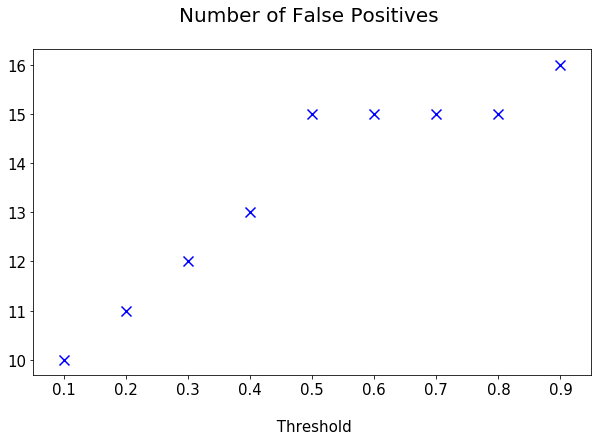

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
plt.scatter(threshlist, fplist, color = 'blue', marker = 'x', s = 100)
plt.title('Number of False Positives \n', fontsize = 20)
plt.xlabel('\n Threshold', fontsize = 15)
plt.xticks(threshlist, fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

## Running the 'train2' classifier on the test set and reporting its performance using a confusion matrix.

In [24]:
report = NB2.score(test_text, test['label'])
print("Confusion matrix: ")
print(report[1])
print('-'*35)
print("Accuracy score: ", report[0])

Confusion matrix: 
[[1786.   64.]
 [   4.  218.]]
-----------------------------------
Accuracy score:  0.9671814671814671


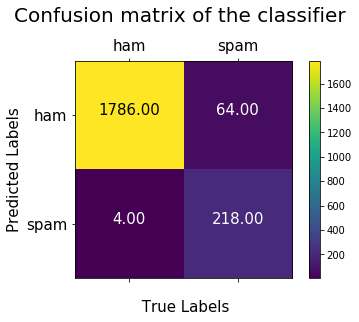

In [26]:
from sklearn.metrics import confusion_matrix
import itertools
labels = ['ham', 'spam']
cm = report[1]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier \n', fontsize = 20)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels, fontsize = 15)
ax.set_yticklabels([''] + labels, fontsize = 15)
fmt = '.2f' 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="black" if cm[i, j] > thresh else "white", fontsize = 15)
plt.xlabel('\n True Labels', fontsize = 15)
plt.ylabel('Predicted Labels', fontsize = 15)
plt.show()